# Titanic - Machine Learning from Disaster

This is the version 2.

Feature added:
- Title: obtained from the Name column.
- Cabin: the new cabin value is the first letter of the old cabin value: we suppose that same first letter means same section.
- FamilySize: just the sum of Parch and SibSp.
- Fare: the old Fare column but categorized.
- Age: the old Age column but categorized.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, LearningCurveDisplay
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

## Define train and test dataframe

In [2]:
# Define train and test dataframe.
train_df = pd.read_csv('train.csv', sep=',')
test_df = pd.read_csv('test.csv', sep=',')

# Drop id col, we don't need it.
train_df = train_df.drop(columns=["PassengerId"], axis=1)

print("Train dataset shape =", train_df.shape)
print(train_df.describe())

print("\nTest dataset shape =", test_df.shape)
print(test_df.describe())

Train dataset shape = (891, 11)
         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

Test dataset shape = (418, 11)
       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.6271

In [3]:
print("First 10 samples in the train dataframe:\n\n", train_df.head(10))

First 10 samples in the train dataframe:

    Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   
5         0       3                                   Moran, Mr. James   
6         0       1                            McCarthy, Mr. Timothy J   
7         0       3                     Palsson, Master. Gosta Leonard   
8         1       3  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
9         1       2                Nasser, Mrs. Nicholas (Adele Achem)   

      Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  
0    male  22.0      1      0         A/5 21171   7.2500   NaN      

## Explore train dataset

In [4]:
# Print distribution split by survival.
def distrib_split_by_survival(df, col_name):
    # Split into survived/not survived
    survived = df[df["Survived"] == 1][col_name].dropna()
    not_survived = df[df["Survived"] == 0][col_name].dropna()
    
    # Create a stacked histogram
    plt.figure(figsize=(10, 6))
    plt.hist([survived, not_survived], bins=30, stacked=True, color=['blue', 'red'], label=['Survived', "Did not survived"], edgecolor='black')
    
    # Add labels and title
    plt.xlabel(col_name)
    plt.ylabel("Count")
    plt.title(f"{col_name} Distribution Split by Survival")
    plt.legend()
    plt.show()

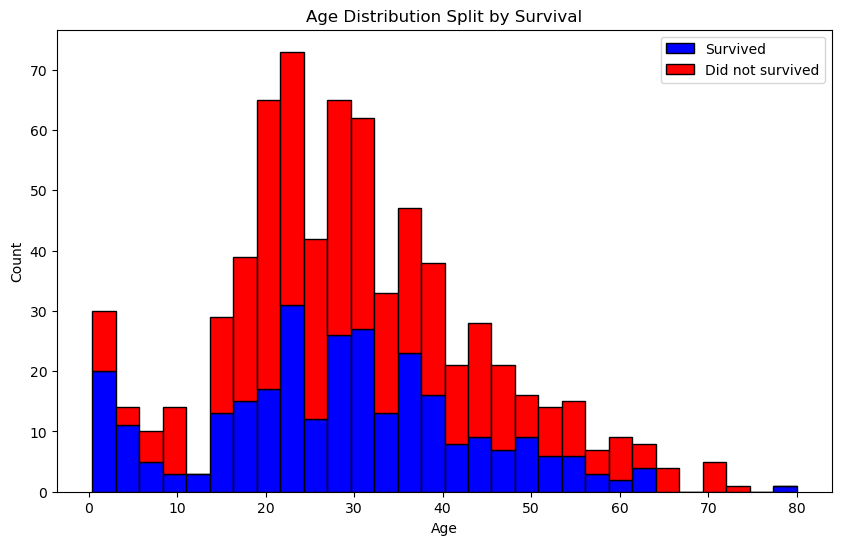

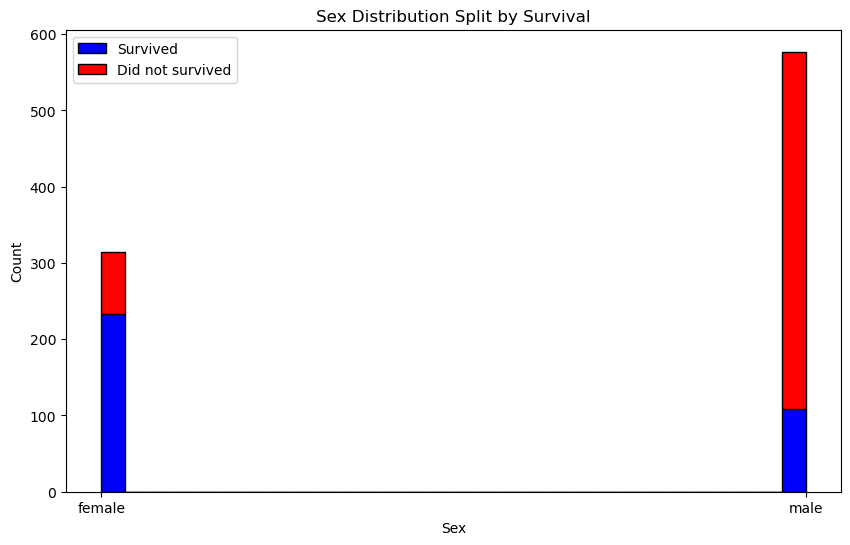

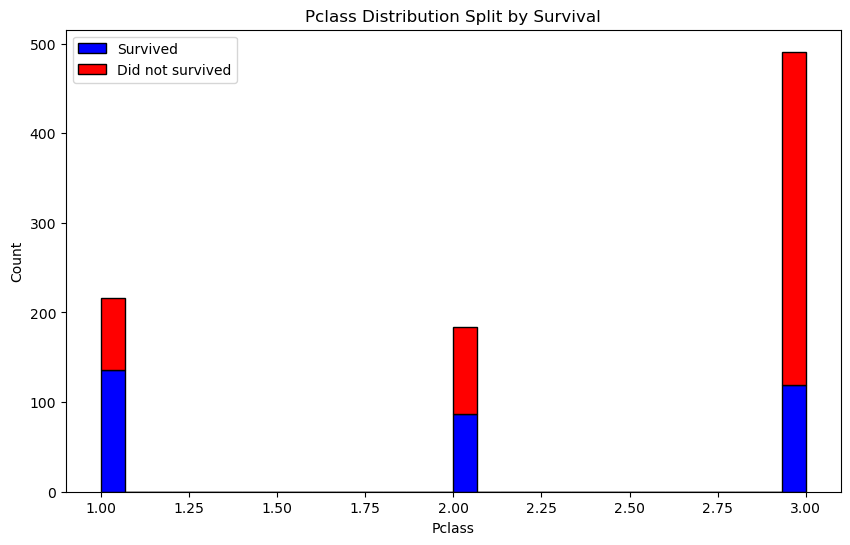

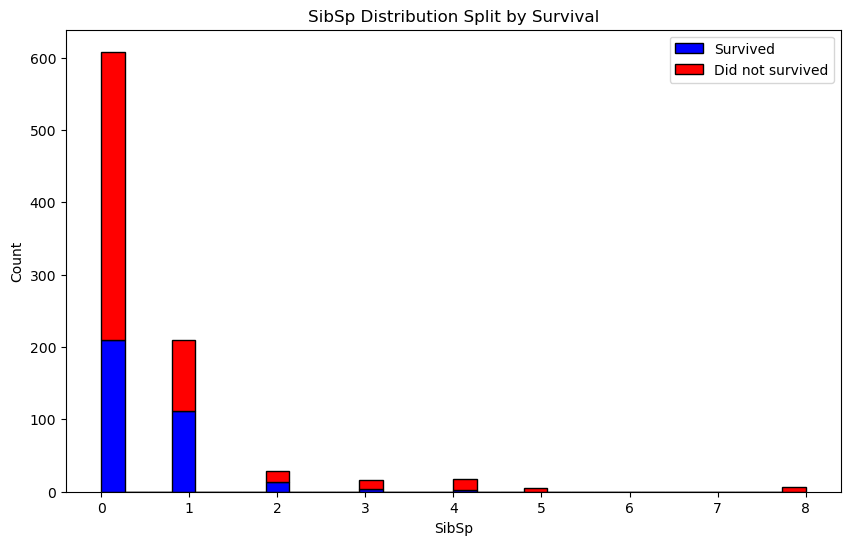

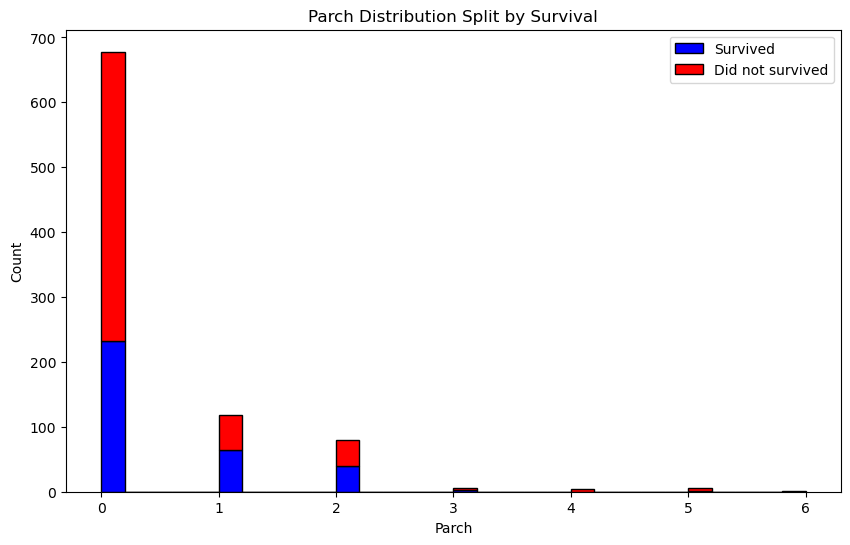

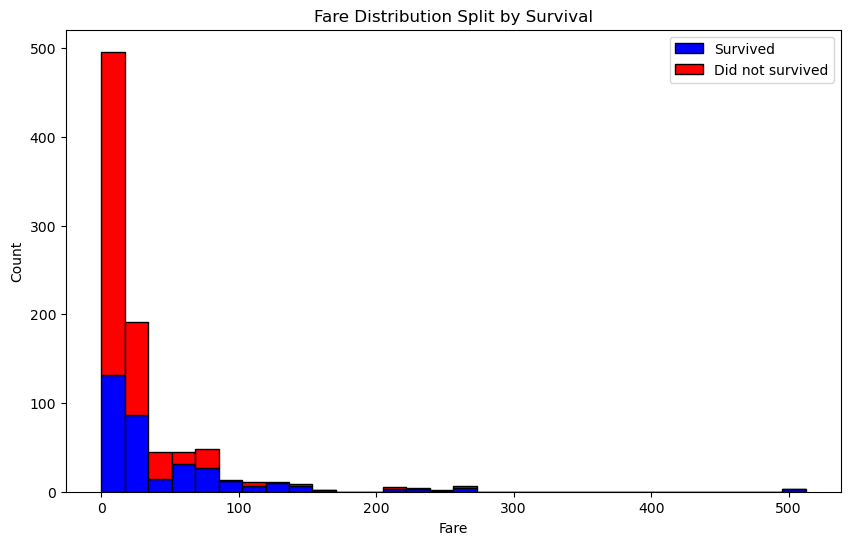

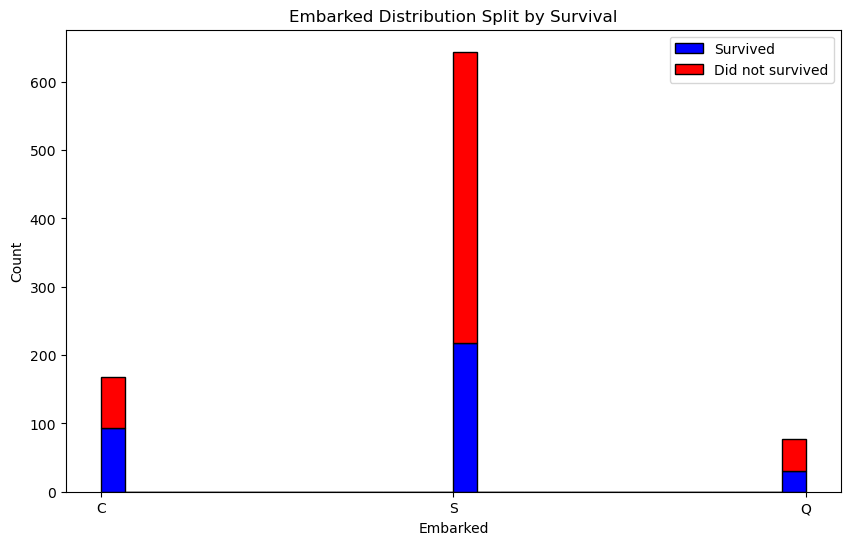

In [5]:
# Print Pclass distribution.
col_names = ["Age", "Sex", "Pclass", "SibSp", "Parch", "Fare", "Embarked"]
for cn in col_names:
    distrib_split_by_survival(train_df, cn)

## Deal with missing values

In [6]:
print("Train dataframe missing values:")
print(train_df.isna().sum())

print("\nTest dataframe missing values:")
print(test_df.isna().sum())

Train dataframe missing values:
Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Test dataframe missing values:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [7]:
# Fill the missing values in Embarked col with the most frequent value, that is 'S'.
train_df["Embarked"] = train_df["Embarked"].fillna('S')

# Fill the missing value in Fare col with the mean.
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].mean())

## Feature engeenering

### Title

In [8]:
# Define a new column called title.
def get_title(name):
    if 'Sir.' in name:
        return 'High'
    elif 'Dr.' in name:
        return 'High'
    elif 'Mr.' in name:
        return 'Mr'
    elif 'Lady' in name:
        return 'High'
    elif 'Countess' in name:
        return 'High'
    elif 'Capt' in name:
        return 'High'
    elif 'Major' in name:
        return 'High'
    elif 'Jonkheer' in name:
        return 'High'
    elif 'Rev' in name:
        return 'High'
    elif 'Col' in name:
        return 'High'
    elif 'Don' in name:
        return 'High'
    elif 'Master' in name:
        return 'Master'
    elif 'Mrs.' in name:
        return 'Mrs'
    elif 'Ms.' in name:
        return 'Mrs'
    elif 'Miss.' in name:
        return 'Miss'
    else:
        return 'N'

# Train dataframe.
title_col = train_df['Name'].apply(get_title)
train_df["Title"] = title_col
print(title_col.value_counts())

# Test dataframe.
test_df["Title"] = test_df['Name'].apply(get_title)

Name
Mr        517
Miss      181
Mrs       125
Master     40
High       25
N           3
Name: count, dtype: int64


### Cabin

In [9]:
# Categorize cabin: take the first letter as new cabin value.
def first_cabin_letter(cabin):
    cabin = str(cabin)
    if cabin == "nan":
        return "FakeCabin"
    return cabin[0]

# Train dataframe.
new_cabin_col = train_df["Cabin"].apply(first_cabin_letter)
train_df["Cabin"] = new_cabin_col
print(new_cabin_col.value_counts())

# Test dataframe.
test_df["Cabin"] = test_df["Cabin"].apply(first_cabin_letter)

Cabin
FakeCabin    687
C             59
B             47
D             33
E             32
A             15
F             13
G              4
T              1
Name: count, dtype: int64


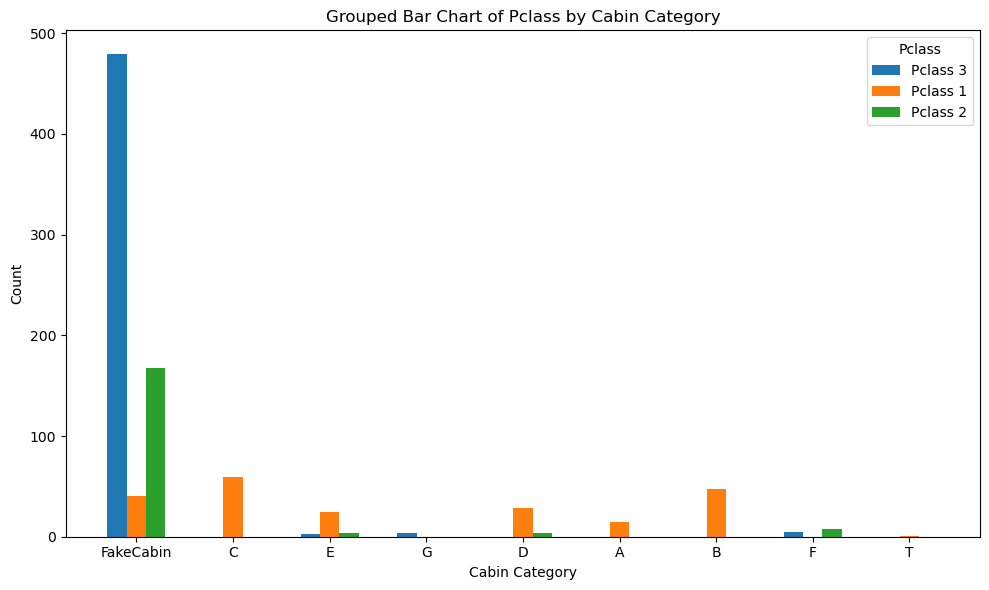

In [10]:
# Print class for each cabin category.
# Categories and classes.
category = train_df["Cabin"].unique()
classes = train_df["Pclass"].unique()

# Count occurrences of each class for each cabin category
counts = {cabin: [len(train_df[(train_df["Cabin"] == cabin) & (train_df["Pclass"] == cls)]) for cls in classes] for cabin in category}

# Create a grouped bar chart.
bar_width = 0.2
x = np.arange(len(category))  # x positions for the groups.

# Plot bars for each class.
plt.figure(figsize=(10, 6))
for i, cls in enumerate(classes):
    plt.bar(x + i * bar_width, [counts[cabin][i] for cabin in category], width=bar_width, label=f"Pclass {cls}")

plt.xticks(x + bar_width, category)  # Center group labels.
plt.xlabel("Cabin Category")
plt.ylabel("Count")
plt.title("Grouped Bar Chart of Pclass by Cabin Category")
plt.legend(title="Pclass")

plt.tight_layout()
plt.show()

Since we have only one passenger in cabin T and since this passenger is in class 1, then we
add him in cabin A (which contains only passenger from class 1).

In [11]:
print(train_df[train_df["Cabin"] == "T"])
train_df.loc[train_df["Cabin"] == "T", "Cabin"] = "A"

     Survived  Pclass                          Name   Sex   Age  SibSp  Parch  \
339         0       1  Blackwell, Mr. Stephen Weart  male  45.0      0      0   

     Ticket  Fare Cabin Embarked Title  
339  113784  35.5     T        S    Mr  


### Family size

Family size = SibSp + Parch

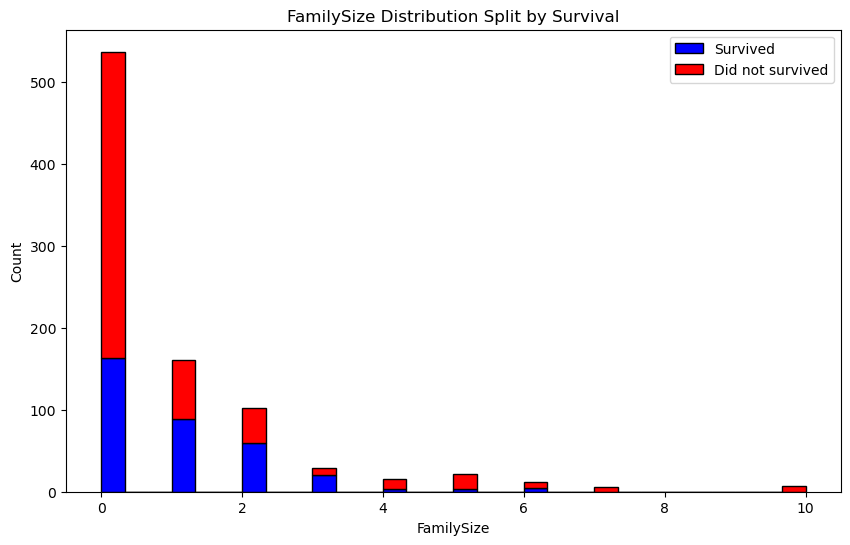

In [12]:
# Add new column called FamilySize.
train_df["FamilySize"] = train_df["Parch"] + train_df["SibSp"]
test_df["FamilySize"] = test_df["Parch"] + test_df["SibSp"]
distrib_split_by_survival(train_df, "FamilySize")

In [13]:
# We can just drop the SibSp and Parch cols.
train_df = train_df.drop(columns=["SibSp", "Parch"], axis=1)
test_df = test_df.drop(columns=["SibSp", "Parch"], axis=1)

### Categorize Fare

In [14]:
def categ_fare(fare):
    if fare <= 10:
        return "Very low"
    elif fare <= 30:
        return "Low"
    elif fare <= 70:
        return "Mid"
    elif fare <= 120:
        return "High"
    else:
        return "Very high"

# Train dataframe.
new_fare_col = train_df["Fare"].apply(categ_fare)
print(new_fare_col.value_counts())
train_df["Fare"] = new_fare_col

# Test dataframe.
test_df["Fare"] = test_df["Fare"].apply(categ_fare)

Fare
Very low     336
Low          321
Mid          129
High          67
Very high     38
Name: count, dtype: int64


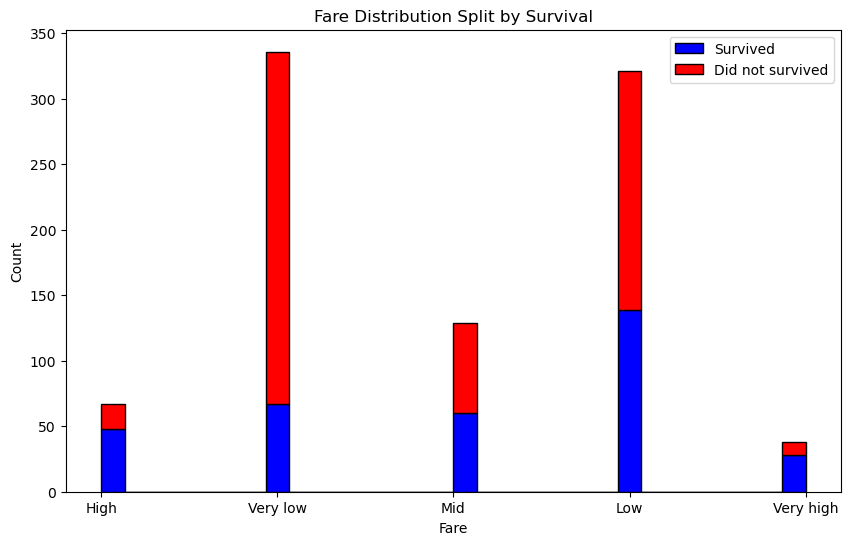

In [15]:
distrib_split_by_survival(train_df, "Fare")

### Drop Name and Ticket

In [16]:
train_df = train_df.drop(columns=["Name", "Ticket"], axis=1)
test_df = test_df.drop(columns=["Name", "Ticket"], axis=1)

### Age

Since age is a very important feature and in both train and test dataframes we're missing many values, we can try something differen.

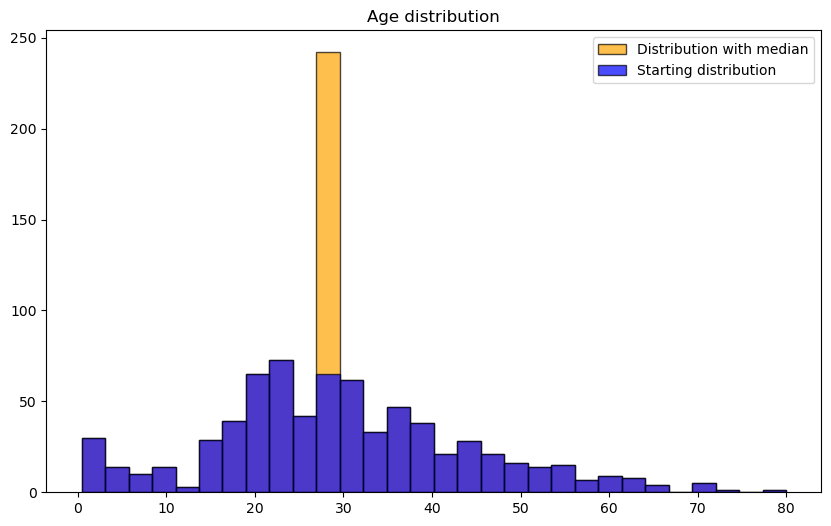

In [17]:
# Try with the median.
median_age_col = train_df['Age'].fillna(train_df['Age'].median())
# Print the distribution.
plt.figure(figsize=(10, 6))
plt.hist(median_age_col.tolist(), bins=30, color='orange', alpha=0.7, edgecolor='black', label="Distribution with median")
plt.hist(train_df["Age"].dropna().tolist(), bins=30, color='blue', alpha=0.7, edgecolor='black', label="Starting distribution")
plt.title("Age distribution")
plt.legend()
plt.show()

Instead of using the median, we will train (in the following sections) a Decision Tree model.

## Encode categorical features

In [18]:
# Matrix with instances.
X_train = train_df.dropna().drop(columns=["Survived"], axis=1)
X_test = test_df.dropna()
# Vector with labels.
Y_train = train_df.dropna()["Survived"]

print("Tot number of samples in train set:", X_train.shape[0])
features_names = list(X_train.columns)
print("Features names:", features_names)

X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values

Tot number of samples in train set: 714
Features names: ['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Title', 'FamilySize']


In [19]:
# Print the data type of each column.
for index_col, name_col in zip(range(X_train.shape[1]), features_names):
    print(f"Column {name_col} (index: {index_col}) -- data type: {type(X_train[0, index_col])}")

Column Pclass (index: 0) -- data type: <class 'int'>
Column Sex (index: 1) -- data type: <class 'str'>
Column Age (index: 2) -- data type: <class 'float'>
Column Fare (index: 3) -- data type: <class 'str'>
Column Cabin (index: 4) -- data type: <class 'str'>
Column Embarked (index: 5) -- data type: <class 'str'>
Column Title (index: 6) -- data type: <class 'str'>
Column FamilySize (index: 7) -- data type: <class 'int'>


In [20]:
# Encode the categorical variables: Sex, Cabin, Embarked, Title.
to_encode = np.array([1, 3, 4, 5, 6])
enc = OrdinalEncoder() # Encoder.
enc.fit(X_train[:, to_encode])
X_train[:, to_encode] = enc.transform(X_train[:, to_encode])
X_test[:, to_encode+1] = enc.transform(X_test[:, to_encode+1])

# Print the data type of each column.
for index_col, name_col in zip(range(X_train.shape[1]), features_names):
    print(f"Column {name_col} (index: {index_col}) -- data type: {type(X_train[0, index_col])}")

Column Pclass (index: 0) -- data type: <class 'int'>
Column Sex (index: 1) -- data type: <class 'float'>
Column Age (index: 2) -- data type: <class 'float'>
Column Fare (index: 3) -- data type: <class 'float'>
Column Cabin (index: 4) -- data type: <class 'float'>
Column Embarked (index: 5) -- data type: <class 'float'>
Column Title (index: 6) -- data type: <class 'float'>
Column FamilySize (index: 7) -- data type: <class 'int'>


## Predict missing age values with Random Forest model

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Optimal param: {'max_depth': 4, 'random_state': 12}


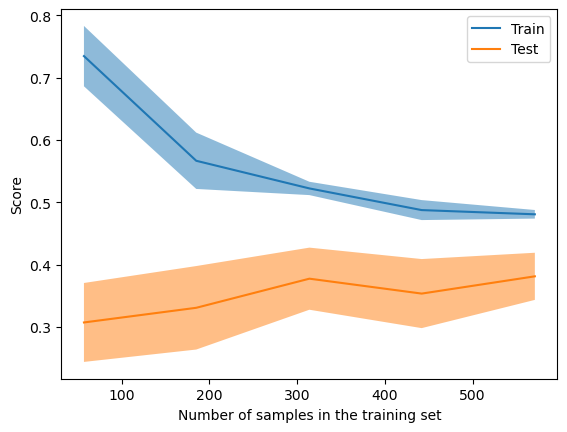

In [21]:
# Use k-cross validation.
X_age_train = X_train[:, [0, 1, 3, 4, 5, 6, 7]]
Y_age_train = X_train[:, [2]]

# Search grid.
param_grid = {
    "max_depth": range(1, 11),
    "random_state": [12]
}

rf_gs = GridSearchCV(RandomForestRegressor(), param_grid, cv=10, verbose=1)
rf_gs.fit(X_age_train, Y_age_train.ravel())
print("Optimal param:", rf_gs.best_params_)
LearningCurveDisplay.from_estimator(rf_gs.best_estimator_, X_age_train, Y_age_train.ravel())

In [22]:
# Predict the missing age values.
to_predict = train_df[train_df["Age"].isna()].drop(columns=["Age", "Survived"], axis=1)
print(to_predict)
to_predict = to_predict.values

# Encode.
to_predict[:, [1, 2, 3, 4, 5]] = enc.transform(to_predict[:, [1, 2, 3, 4, 5]])

# Predict the age.
missing_age = rf_gs.best_estimator_.predict(to_predict)

     Pclass     Sex      Fare      Cabin Embarked Title  FamilySize
5         3    male  Very low  FakeCabin        Q    Mr           0
17        2    male       Low  FakeCabin        S    Mr           0
19        3  female  Very low  FakeCabin        C   Mrs           0
26        3    male  Very low  FakeCabin        C    Mr           0
28        3  female  Very low  FakeCabin        Q  Miss           0
..      ...     ...       ...        ...      ...   ...         ...
859       3    male  Very low  FakeCabin        C    Mr           0
863       3  female       Mid  FakeCabin        S  Miss          10
868       3    male  Very low  FakeCabin        S    Mr           0
878       3    male  Very low  FakeCabin        S    Mr           0
888       3  female       Low  FakeCabin        S  Miss           3

[177 rows x 7 columns]


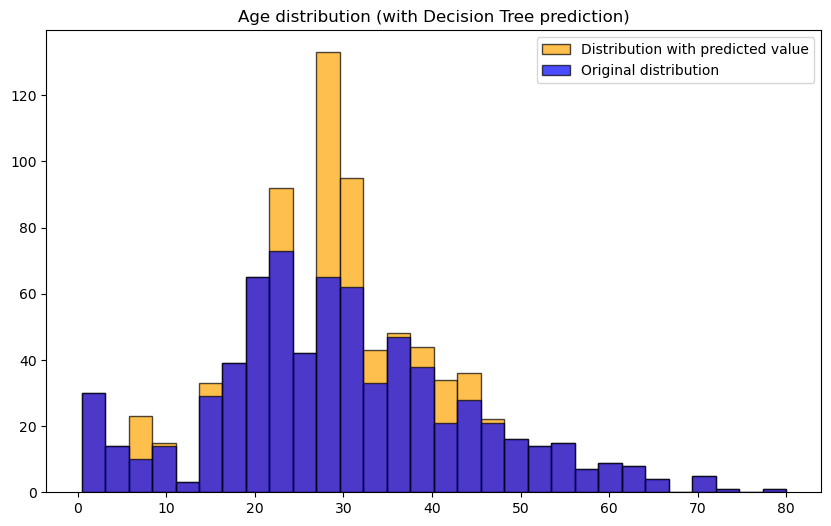

In [23]:
# Print the distribution.
plt.figure(figsize=(10, 6))
plt.hist(np.append(missing_age, X_train[:, 2]) , bins=30, color='orange', alpha=0.7, edgecolor='black', label="Distribution with predicted value")
plt.hist(X_train[:, 2], bins=30, color='blue', alpha=0.7, edgecolor='black', label="Original distribution")
plt.title("Age distribution (with Decision Tree prediction)")
plt.legend()
plt.show()

In [24]:
# Now we add samples with the predicted value to the train set.
X_train = np.vstack((X_train, np.insert(to_predict, 2, missing_age, axis=1)))
Y_train = np.append(Y_train, train_df[train_df["Age"].isna()]["Survived"])
print(X_train.shape)
print(Y_train.shape)

(891, 8)
(891,)


In [25]:
# Predict the missing data values of the test set.
to_predict = test_df[test_df["Age"].isna()].drop(columns=["Age"], axis=1)
print(to_predict)
to_predict = to_predict.values

# Encode.
to_predict[:, [2, 3, 4, 5, 6]] = enc.transform(to_predict[:, [2, 3, 4, 5, 6]])

# Predict the age.
missing_age = rf_gs.best_estimator_.predict(to_predict[:, 1:])

# Add the samples with the predicted value to the test set.
X_test = np.vstack((X_test, np.insert(to_predict, 3, missing_age, axis=1)))
print(X_test.shape)

     PassengerId  Pclass     Sex      Fare      Cabin Embarked   Title  \
10           902       3    male  Very low  FakeCabin        S      Mr   
22           914       1  female       Mid  FakeCabin        S     Mrs   
29           921       3    male       Low  FakeCabin        C      Mr   
33           925       3  female       Low  FakeCabin        S     Mrs   
36           928       3  female  Very low  FakeCabin        S    Miss   
..           ...     ...     ...       ...        ...      ...     ...   
408         1300       3  female  Very low  FakeCabin        Q    Miss   
410         1302       3  female  Very low  FakeCabin        Q    Miss   
413         1305       3    male  Very low  FakeCabin        S      Mr   
416         1308       3    male  Very low  FakeCabin        S      Mr   
417         1309       3    male       Low  FakeCabin        C  Master   

     FamilySize  
10            0  
22            0  
29            2  
33            3  
36            0  
.. 

### Categorize Age

In [26]:
def categ_age(age):
    if age <= 12:
        return "Child"
    elif age <= 20:
        return "Teenager"
    elif age <= 30:
        return "Young adult"
    elif age <= 60:
        return "Adult"
    else:
        return "Elderly"

# Train dataframe.
new_age_col = []
for row in X_train:
    new_age_col.append(categ_age(row[2]))
print(pd.DataFrame(new_age_col).value_counts())
for i, c_age in enumerate(new_age_col):
    X_train[i, 2] = c_age

enc.fit(X_train[:, [2]])
X_train[:, [2]] = enc.transform(X_train[:, [2]])
    
# Test dataframe.
for i in range(X_test.shape[0]):
    X_test[i, 3] = categ_age(X_test[i, 3])
X_test[:, [3]] = enc.transform(X_test[:, [3]])

0          
Adult          353
Young adult    319
Teenager       114
Child           83
Elderly         22
Name: count, dtype: int64


## Split train dataframe into train and validation set.

In [27]:
m = X_train.shape[0]
m_train = int(4./5. * m)
m_val = m - m_train

print("Amount of data for training set:", m_train)
print("Amount of data for validation set", m_val)

# Split into train and validation.
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=m_val/m, random_state=12)

# Check size of sets.
print("Training size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])

Amount of data for training set: 712
Amount of data for validation set 179
Training size: 712
Validation size: 179


## Standardize data

In [28]:
# We don't have any continuous feature.
## Standardize age and fare columns.
#to_scale = np.array([2])
#
## Create a copy for each set.
#X_train_scaled = np.copy(X_train)
#X_val_scaled = np.copy(X_val)
#X_test_scaled = np.copy(X_test)
#
## Scale data.
#scaler = StandardScaler().fit(X_train[:, to_scale])
#X_train_scaled[:, to_scale] = scaler.transform(X_train[:, to_scale])
#X_val_scaled[:, to_scale] = scaler.transform(X_val[:, to_scale])
#X_test_scaled[:, to_scale+1] = scaler.transform(X_test[:, to_scale+1])

## Train Random Forest model

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Optimal param: {'max_depth': 5, 'random_state': 12}


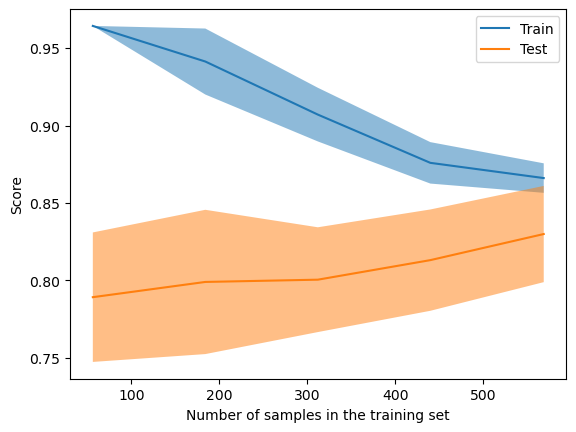

In [29]:
# Find best value for max depth.
param_grid = {
    "max_depth": range(1, 11), 
    "random_state": [12]
}
rf_gs = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, verbose=1)
rf_gs.fit(X_train, Y_train)
print("Optimal param:", rf_gs.best_params_)
LearningCurveDisplay.from_estimator(rf_gs.best_estimator_, X_train, Y_train)

In [30]:
print("Validation score:", rf_gs.best_estimator_.score(X_val, Y_val))

Validation score: 0.8100558659217877


## Create submission

In [31]:
# Compute predictions.
predictions = rf_gs.best_estimator_.predict(X_test[:, 1:])

# Save predictions.
output = pd.DataFrame({'PassengerId': X_test[:, [0]].flatten(), 'Survived': predictions}) 
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
